In [1]:
print("Hello World")

Hello World


In [2]:
readFile="Data/parquet/subSampleWholeDataSet"

Most of my methods have yielded good results and which would most easily be improved by dropping parts of the dataset. The dataset itself is artificial, and there would be more useful things to find than tuning it to gain a couple of percentage points improvment. SKLearn has some new gridfeatures that I wanted to try:
https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

In [3]:
! PYTHONHASHSEED=0
import pandas as pd
import numpy as np

In [4]:
dataset=pd.read_parquet(readFile, engine='pyarrow')

In [5]:
 from sklearn.preprocessing import LabelEncoder, OneHotEncoder

We will use the slightly extended number of features

In [6]:
categoricalCols = [
    "wlan_tag_length",
    "wlan_country_info_fnm",
    "wlan_da",
    "wlan_sa",
    "wlan_bssid",
    "ip_src",
    "ip_dst",
    "http_host",
    "http_request_line",
    "http_request_method",
    "http_request_version",
    "ssdp",
    "http_request_full_uri"
]


In [7]:
numericCols=[
    "wlan_fixed_reason_code",
    "radiotap_channel_freq",
    "udp_length",
    "ip_ttl",
    "udp_dstport",
    "udp_time_delta"
]

In [8]:
y=dataset['label']
x=dataset[categoricalCols+numericCols]
x[categoricalCols].astype("category")

,wlan_tag_length,wlan_country_info_fnm,wlan_da,wlan_sa,wlan_bssid,ip_src,ip_dst,http_host,http_request_line,http_request_method,http_request_version,ssdp,http_request_full_uri
0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,NA,NA,50:3e:aa:e4:01:93,00:0c:29:cf:08:aa,0c:9d:92:54:fe:34,192.168.2.130,192.168.2.73,NA,NA,NA,NA,NA,NA
4,NA,NA,50:3e:aa:e4:01:93,00:0c:29:cf:08:aa,0c:9d:92:54:fe:34,192.168.2.130,192.168.2.73,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632402,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
632403,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
632404,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
632405,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
from sklearn.preprocessing import FunctionTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categoricalCols)
    ]
)

We have our pieline set up and now make our test train split.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV


So the DecisionTreeClassifier gives as good results as the other trees, we probably wont use it as there are fewer parameters to tune for the final model but it gives a good baseline. Next Random Forest

In [ ]:

base_estimator = Pipeline(steps=[("preprocess", preprocessor), ("RFclassifier", RandomForestClassifier(random_state=0))])


In [ ]:
param_grid = {'RFclassifier__max_features': ['auto', 'log2']}

In [ ]:
%%time
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=3,
    factor=2, resource='RFclassifier__n_estimators',
    max_resources=600,aggressive_elimination=True,n_jobs=6).fit(x, y)

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 9min 34s, sys: 1.71 s, total: 9min 35s
Wall time: 42min 47s


In [52]:
sh.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['wlan_tag_length',
                                                   'wlan_country_info_fnm',
                                                   'wlan_da', 'wlan_sa',
                                                   'wlan_bssid', 'ip_src',
                                                   'ip_dst', 'http_host',
                                                   'http_request_line',
                                                   'http_request_method',
                                                   'http_request_version',
                                                   'ssdp',
                                                   'http_request_full_uri'])])),
                ('RFclassifier',
                 RandomForestClassifier(n_estimators=600, ra

so this suggests that improvement continues with 600 and even more would be better lets see how this works with the model

In [53]:
TunedRF = Pipeline(steps=[("preprocess", preprocessor), ("RFclassifier", RandomForestClassifier(max_depth=None, min_samples_split=2,max_features='log2',criterion='gini',n_estimators=600,random_state=0))])

In [54]:
%%time
TunedRF.fit(X_train, y_train)
print("The model score for a RandomForestClassifier: %.3f" % TunedRF.score(X_test, y_test))
testPredictions=TunedRF.predict(X_test)

The model score for a RandomForestClassifier: 0.991
CPU times: user 14min 36s, sys: 135 ms, total: 14min 36s
Wall time: 14min 36s


In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
tn, fp, fn, tp = confusion_matrix(y_test, testPredictions).ravel()
precision,recall,fscore,support = precision_recall_fscore_support(y_test, testPredictions, average='binary')
MCC = matthews_corrcoef(y_test, testPredictions)
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC))

There are 119074 true negatives
There are 6300 true positives
There are 801 false negatives
There are 307 false positives
The precision is 0.9535341304676858
The recall is 0.8871989860583016
The fscore is 0.9191712868398016
The Matthews correlation coefficient is 0.9152111022255177


so compared to the comparing trees notebook which used 100 we get slightly better results but only at the 5 decimal point for the MCC. This shows linear scaling with the number of trees, 100 took 151s 600 trees took 876s so 5.8 times longer. Not an issue with the subsample ubt would be with the full dataset. 


I think there is a limit to how much more improvement we can get from tuning, but to show how you can print out the results of a grid search I adapted this page:
https://sklearn-evaluation.readthedocs.io/en/latest/user_guide/grid_search.html
However the results are hard to visualise, as the results are all very good, because every classifier get the vast majority correct by getting the true posatives correct.

In [62]:
hyperparameters = {
    'RFclassifier__n_estimators': [1, 10, 50, 100],
    'RFclassifier__criterion': ['gini', 'entropy'],
    'RFclassifier__max_features': ['sqrt', 'log2'],
}

In [63]:
estimator = Pipeline(steps=[("preprocess", preprocessor), ("RFclassifier", RandomForestClassifier(n_estimators=5, random_state=0))])
clf = GridSearchCV(estimator, hyperparameters, cv=3)
clf.fit(x, y)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['wlan_tag_length',
                                                                          'wlan_country_info_fnm',
                                                                          'wlan_da',
                                                                          'wlan_sa',
                                                                          'wlan_bssid',
                                                                          'ip_src',
                                                                          'ip_dst',
                                                                          'http_host',
                             

In [ ]:
!pip install sklearn-evaluation

<AxesSubplot:>

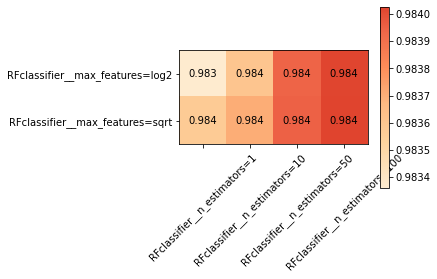

In [84]:
plot.grid_search(clf.cv_results_, change=('RFclassifier__n_estimators', 'RFclassifier__max_features'),
                 subset={'RFclassifier__criterion': 'gini'})

This chart shows accuracy so is not the best for our purposes but there is almost no change visibile at the number of decimal places that are used. This was one of the challenges with visualisation on this project, the built in methods are intended for smaller datasets with larger differences in results